In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import datetime
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [207]:
actor_template = ChatPromptTemplate.from_messages(
    [
        (
            "system", 
            """
            You are an expert researcher
            Current time: {time}

            1. {first_instruction}
            2. Reflect and Critique your answer. Be severe to maximize your improvement.
            3. Recommend search queries to research information and improve your answer. 
            """
        ),
        MessagesPlaceholder(variable_name = "messages"),
        (
            "system", "Answer the user's question above using the necessary format."
        )
    ]
)

In [208]:
actor_template = actor_template.partial(time = datetime.datetime.now().isoformat())

In [233]:
llm = ChatOpenAI(model = "o4-mini")

In [234]:
from pydantic import BaseModel, Field
from typing import List

In [235]:
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing")
    unnecessary: str = Field(description="Critique of what is unnecessary")

In [236]:
class AnswerQuestion(BaseModel):
    """Answer the question."""
    answer: str = Field(description="Detailed Answer to the query in around 250 words")
    reflection: Reflection = Field(description="Your reflection on the initial response")
    search_string: List[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

In [237]:
from langchain_core.output_parsers.openai_tools import JsonOutputToolsParser, PydanticToolsParser

In [238]:
parser = JsonOutputToolsParser(return_id = True)

In [239]:
parser_pydantic = PydanticToolsParser(tools=[AnswerQuestion])

In [240]:
first_responder_template = actor_template.partial(first_instruction = "Provide a detailed~250 word answer")

In [241]:
first_responder = (
    first_responder_template | 
    llm.bind_tools(tools = [AnswerQuestion], tool_choice="AnswerQuestion") |
    parser_pydantic
)

In [242]:
chain_responder = (
    first_responder_template |
    llm.bind_tools(tools = [AnswerQuestion], tool_choice="AnswerQuestion")
)

In [243]:
human_message = HumanMessage(content = """
Write about AI-powered SOC / autonomous problem domain, List startups which does this and raises captial.
""")

In [244]:
response = first_responder.invoke({
    "messages": [human_message]
})

In [245]:
response[0].answer

'An AI-powered Security Operations Center (SOC) leverages machine learning, behavioral analytics and automation to detect, investigate and remediate cyber threats at machine speed. In the autonomous problem domain, these platforms ingest vast telemetry—network flows, endpoint logs, cloud events—and apply AI models for anomaly detection, threat hunting and predictive risk scoring. When a suspicious pattern emerges, automated playbooks can triage alerts, gather contextual data (e.g., threat intelligence, asset risk), escalate high-priority incidents, and even orchestrate response actions such as network quarantines or endpoint isolation without human intervention.\n\nKey Benefits:\n• Speed: Real-time threat identification and response reduces dwell time from days to minutes.  \n• Efficiency: AI filters out false positives and automates routine tasks, allowing human analysts to focus on complex investigations.  \n• Scalability: As enterprise attack surface grows, AI-driven SOCs scale hori

In [246]:
response[0].reflection

Reflection(missing='Specific customer success metrics, comparative performance data, and deeper technical architecture details (e.g. types of ML models used).', unnecessary='General background on AI benefits that are well-known; could be more concise on common benefits to focus on unique differentiators of each startup.')

In [247]:
response[0].search_string

['AI-powered SOC startups funding',
 'autonomous SOC problem domain market report',
 'AI SOC automation funding list']

In [248]:
class ReviseAnswer(BaseModel):
    """Revise your original answer to your question."""
    references: List[str] = Field(
        description = "Citations Motivating the answer" 
    )

In [288]:
revise_instruction = """
Revise your previous answer using the new information.
-  You should use the previous critique to add importatnt information.
    - You must include numerical citations in your revised answer to ensure it can be verified.
    - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
        - [1] https://example.com
        - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

In [289]:
revisor = actor_template.partial(first_instruction = revise_instruction)

In [290]:
chain_revisor = (
    revisor |
    llm.bind_tools(tools = [ReviseAnswer], tool_choice = "ReviseAnswer")
)

In [291]:
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode
from langchain_core.tools import StructuredTool

In [292]:
tavily_search = TavilySearch(max_result = 5)

In [293]:
def run_queries(search_string: list[str], **kwargs):
    """
    Runs Google search for all the queries
    """
    return tavily_search.batch([{"query" : query} for query in search_string])

In [294]:
executor_node = ToolNode(
    tools=[
        StructuredTool.from_function(func=run_queries, name = AnswerQuestion.__name__),
        StructuredTool.from_function(func=run_queries, name = ReviseAnswer.__name__)
    ]
)

In [321]:
sample_tool = StructuredTool.from_function(func=run_queries, name = ReviseAnswer.__name__)

In [324]:
sample_tool.dict()

/var/folders/xg/ffmlt01s6576w5wrhsp6ljqh0000gq/T/ipykernel_12984/1416035030.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  sample_tool.dict()


{'name': 'ReviseAnswer',
 'description': 'Runs Google search for all the queries',
 'args_schema': langchain_core.utils.pydantic.ReviseAnswer,
 'return_direct': False,
 'verbose': False,
 'tags': None,
 'metadata': None,
 'handle_tool_error': False,
 'handle_validation_error': False,
 'response_format': 'content',
 'func': <function __main__.run_queries(search_string: list[str], **kwargs)>,
 'coroutine': None}

In [295]:
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, ToolMessage
from langgraph.graph import MessageGraph, END, START
from typing import List

In [296]:
builder = MessageGraph()

In [297]:
builder.add_node("first_responder", chain_responder)

In [298]:
builder.add_node("revisor_node", chain_revisor)

In [299]:
builder.add_node("tool_node", executor_node)

In [300]:
builder.add_edge(START, "first_responder")

In [301]:
builder.add_edge("first_responder", "tool_node")

In [302]:
builder.add_edge("tool_node", "revisor_node")

In [303]:
def should_end_or_continue(state: List[BaseMessage]) -> str:
    if sum([isinstance(state_msg, ToolMessage) for state_msg in state]) <= 2:
        return "should_continue"

    return "should_end"

In [304]:
builder.add_conditional_edges("revisor_node", should_end_or_continue, {"should_continue": "tool_node", "should_end": END})

In [305]:
flow = builder.compile()

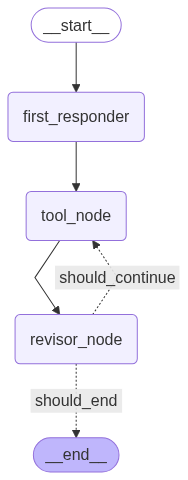

In [306]:
flow

In [307]:
response_field = flow.invoke(
    "Write about AI-Powered SOC / autonomous soc problem domain, list startups that do that and raised capital"
)

In [319]:
response_field[3].tool_calls[0]["args"]

{'references': ['https://justainews.com/companies/funding-news/conifers-ai-raises-25m/',
  'https://www.securityweek.com/intezer-raises-33m-to-extend-ai-powered-soc-platform/',
  'https://redcanary.com/news/red-canary-raises-34m-series-b/',
  'https://www.isai.vc/news/devo-announces-100-million-funding-round']}

In [309]:
response_field[4]

ToolMessage(content="Error: 1 validation error for ReviseAnswer\nsearch_string\n  Field required [type=missing, input_value={'references': ['https://...million-funding-round']}, input_type=dict]\n    For further information visit https://errors.pydantic.dev/2.11/v/missing\n Please fix your mistakes.", name='ReviseAnswer', id='7a6dd271-f231-4f59-a25d-c03ef7d32013', tool_call_id='call_AQOfpLiQ5vAKYmqCLVUBIWmO', status='error')

In [281]:
import json
json.loads(response_field[2].content)

[{'query': 'AI-powered SOC startups funding raised capital',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'title': 'AI-Powered SOCs? Conifers.ai Lands $25M to Make It a Reality',
    'url': 'https://justainews.com/companies/funding-news/conifers-ai-raises-25m/',
    'content': "Conifers.ai has raised $25 million in funding, a major milestone in its journey to enhance security operations centers (SOCs) with AI-powered technology.The investment comes from SYN Ventures, Picus Capital, and other strategic investors, who believe in the company's vision for a smarter and more effective approach to cybersecurity.. Although the company has not disclosed its valuation, this",
    'score': 0.90039873,
    'raw_content': None},
   {'title': 'Intezer Raises $33M to Extend AI-Powered SOC Platform',
    'url': 'https://www.securityweek.com/intezer-raises-33m-to-extend-ai-powered-soc-platform/',
    'content': "The company plans to use the new capital on R&D and to 

In [269]:
response_field

[HumanMessage(content='Write about AI-Powered SOC / autonomous soc problem domain, list startups that do that and raised capital', additional_kwargs={}, response_metadata={}, id='b43a1502-0de3-4fd4-8151-0b71a7d067ad'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HUi1xDIqQuqpZdLooq02ZUyD', 'function': {'arguments': '{"answer":"As organizations struggle to keep pace with the volume, velocity and sophistication of modern cyber-attacks, traditional Security Operations Centers (SOCs) have become overwhelmed by alert fatigue, talent shortages and manual processes. The AI-Powered or Autonomous SOC problem domain addresses these challenges by embedding machine learning, behavioral analytics and automated orchestration directly into the detection-to-response workflow. Such platforms continuously ingest telemetry from endpoints, networks and cloud workloads, applying anomaly detection and correlation engines to surface high-fidelity threats. Within seconds they can tria